In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16704199940659993336
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6186123470824989406
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE=64

In [4]:
column_names = ["lemmatized_clean_text", "labels"]
data = pd.read_csv("../Preprocessed_Dataset/ISOT_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[column_names]
train, test = train_test_split(data, test_size=0.2)

In [5]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(data[column_names[0]])
vocab_size = len(token.word_index) + 2

In [6]:
embedding_vector = {}
f = open('../data/glove.6B.100d.txt')
# for line in tqdm(f):
#     value = line.split(' ')
#     word = value[0]
#     coef = np.array(value[1:],dtype = 'float32')
#     embedding_vector[word] = coef
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:09, 41930.18it/s]
100%|██████████| 131653/131653 [00:00<00:00, 1911422.32it/s]


### Model

In [7]:
# inputs = keras.Input(shape=(None,), name="input")
# x = layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
#                      embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
#                      input_length=SEQUENCE_LENGTH, trainable = False)(inputs)
# x = layers.Conv1D(128, 5, activation='relu', use_bias=False, name="Conv1D")(x)
# x = layers.MaxPooling1D(pool_size=2, name="MaxPooling1D")(x)
# x = layers.LSTM(32, activation=None, use_bias=False, name="LSTM")(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs, outputs)
# model.summary()
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
#     "accuracy",
# ])
model = keras.models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                     input_length=SEQUENCE_LENGTH, trainable = False))
# model.add(layers.Permute((2, 1)))
# model.add(layers.Conv1D(128, 5, activation='relu', name="Conv1D"))
# model.add(layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
model.add(layers.LSTM(32, activation="tanh", name="LSTM"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
    "accuracy",
    tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          13165500  
_________________________________________________________________
LSTM (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,182,557
Trainable params: 17,057
Non-trainable params: 13,165,500
_________________________________________________________________


In [8]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")


In [9]:
epochs = 10
history = model.fit(x=train_x, y=train[column_names[1]], validation_split=0.2,
          epochs=epochs, batch_size=BATCH_SIZE)

Epoch 1/10
449/449 [==============================] - 16s 25ms/step - loss: 0.6775 - accuracy: 0.5682 - precision: 0.5642 - recall: 0.4058 - val_loss: 0.6774 - val_accuracy: 0.5714 - val_precision: 0.6896 - val_recall: 0.1842
Epoch 2/10
449/449 [==============================] - 10s 23ms/step - loss: 0.6593 - accuracy: 0.6020 - precision: 0.6122 - recall: 0.4455 - val_loss: 0.6334 - val_accuracy: 0.6321 - val_precision: 0.6541 - val_recall: 0.4851
Epoch 3/10
449/449 [==============================] - 10s 22ms/step - loss: 0.6580 - accuracy: 0.5965 - precision: 0.5958 - recall: 0.4717 - val_loss: 0.6485 - val_accuracy: 0.6054 - val_precision: 0.6187 - val_recall: 0.4495
Epoch 4/10
449/449 [==============================] - 10s 22ms/step - loss: 0.6521 - accuracy: 0.6161 - precision: 0.6192 - recall: 0.5015 - val_loss: 0.6344 - val_accuracy: 0.6624 - val_precision: 0.6270 - val_recall: 0.7212
Epoch 5/10
449/449 [==============================] - 10s 23ms/step - loss: 0.6220 - accuracy: 0

In [10]:
test_x = token.texts_to_sequences(test[column_names[0]])
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
loss, accuracy, precision, recall = model.evaluate(x=test_x, y=test[column_names[1]])
F1 = 2 * (precision * recall) / (precision + recall)
F1

281/281 [==============================] - 3s 12ms/step - loss: 0.5794 - accuracy: 0.7020 - precision: 0.6395 - recall: 0.8730


0.7382116802640835

In [11]:
from matplotlib import pyplot as plt

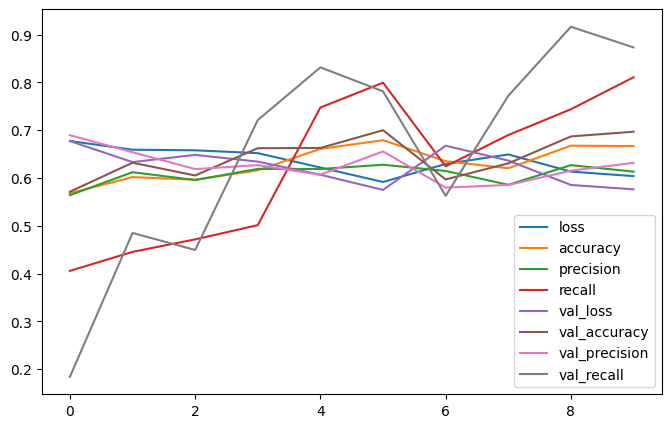

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

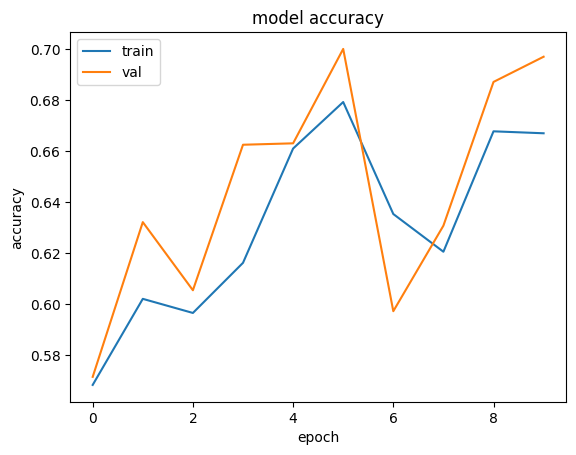

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

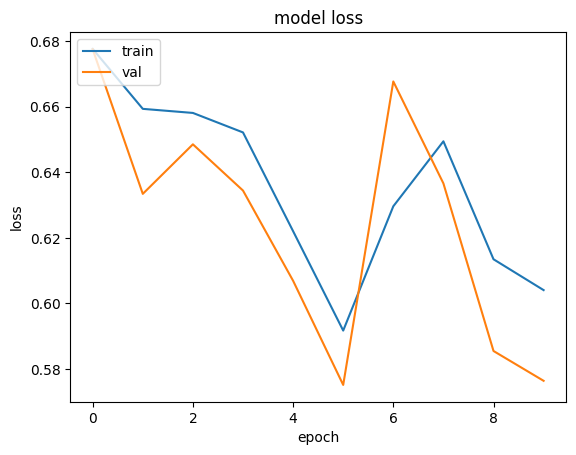

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
model.save("RNN_ISOT")

INFO:tensorflow:Assets written to: RNN_ISOT\assets


INFO:tensorflow:Assets written to: RNN_ISOT\assets
